# Training CNN model

In [1]:
#Importing the libraries

import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
!pip install imutils
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25861 sha256=666136aef2583cdeb939b646279e3a60264c0f9abe777f7dc983da1c0bcac4b1
  Stored in directory: /root/.cache/pip/wheels/35/e4/69/cb99d996d14a2971b79b990d68b05a17d58ce530ff96090dfc
Successfully built imutils


In [2]:
#Loading training and validation data
dir = "/kaggle/input/standard-ocr-dataset/data/training_data"
train_data = []
val_data = []
img_size = 32

for i in os.listdir(dir):
    sub_directory = os.path.join(dir,i)
    cnt = 0
    for j in os.listdir(sub_directory):
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        if cnt < 516:                    #split data into train and validation
            train_data.append([img,i])
        else:
            val_data.append([img,i])
        cnt += 1

In [3]:
print(len(train_data), len(val_data))  #Get size of training and validation data

18576 2052


In [4]:
#Loading test data
test_dir = "/kaggle/input/standard-ocr-dataset/data/testing_data"
test_data = []
img_size = 32
for i in os.listdir(test_dir):
    sub_directory = os.path.join(test_dir,i)
    for j in os.listdir(sub_directory):
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        test_data.append([img,i])

In [5]:
len(test_data)  #Get size of test data

1008

In [6]:
#Shuffling the data
random.shuffle(train_data)
random.shuffle(val_data)

In [7]:
#Splitting the training data into features and labels
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [8]:
#Splitting the validation data into features and labels
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [9]:
#Splitting the test data into features and labels
test_X = []
test_Y = []
for features,label in test_data:
    test_X.append(features)
    test_Y.append(label)

In [10]:
#Using LabelBinarizer to convert labels into one-hot encoded vectors
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)
test_Y = LB.fit_transform(test_Y)

In [11]:
#Reshaping the train data
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [12]:
#Reshaping the validation data
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [13]:
#Reshaping the test data
test_X = np.array(test_X)/255.0
test_X = test_X.reshape(-1,32,32,1)
test_Y = np.array(test_Y)

In [14]:
print(train_X.shape,val_X.shape, test_X.shape)  #Get shape of train, validation and test data

(18576, 32, 32, 1) (2052, 32, 32, 1) (1008, 32, 32, 1)


In [15]:
print(train_Y.shape,val_Y.shape, test_Y.shape) #Get shape of train, validation and test labels

(18576, 36) (2052, 36) (1008, 36)


In [16]:
#Create CNN Model using Keras

model = Sequential()                                                                      #Initialising the model

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1))) #Adding first convolutional layer
model.add(MaxPooling2D(pool_size=(2,2)))                                                  #Adding first MaxPooling layer

model.add(Conv2D(64, (3, 3), activation='relu'))                                          #Adding second convolutional layer
model.add(MaxPooling2D(pool_size=(2,2)))                                                  #Adding second MaxPooling layer

model.add(Conv2D(128, (3, 3), activation='relu'))                                         #Adding third convolutional layer
model.add(MaxPooling2D(pool_size=(2,2)))                                                  #Adding third MaxPooling layer

model.add(Dropout(0.25))                                                                  #Adding Dropout layer
 
model.add(Flatten())                                                                      #Adding Flatten layer

model.add(Dense(128, activation='relu'))                                                  #Adding first Dense layer

model.add(Dropout(0.2))                                                                   #Adding Dropout layer
model.add(Dense(36, activation='softmax'))                                                #Adding final layer with softmax activation function and 36 classes

In [17]:
model.summary() #Get summary of the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [18]:
#Compiling the model
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy']) 

In [19]:
#Learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [20]:
#Fitting/Training the model for 50 epochs
history = model.fit(train_X,train_Y, epochs=50, batch_size=32, validation_data = (val_X, val_Y),  verbose=1, callbacks=[learning_rate_reduction])

Epoch 1/50


2023-04-04 21:40:09.061890: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


581/581 [==============================] - 11s 5ms/step - loss: 1.1550 - accuracy: 0.6750 - val_loss: 0.3888 - val_accuracy: 0.8835 - lr: 0.0010
Epoch 2/50
581/581 [==============================] - 3s 5ms/step - loss: 0.3864 - accuracy: 0.8836 - val_loss: 0.2846 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 3/50
581/581 [==============================] - 3s 5ms/step - loss: 0.2788 - accuracy: 0.9127 - val_loss: 0.2338 - val_accuracy: 0.9298 - lr: 0.0010
Epoch 4/50
581/581 [==============================] - 3s 5ms/step - loss: 0.2349 - accuracy: 0.9228 - val_loss: 0.2009 - val_accuracy: 0.9357 - lr: 0.0010
Epoch 5/50
581/581 [==============================] - 3s 5ms/step - loss: 0.1980 - accuracy: 0.9347 - val_loss: 0.1818 - val_accuracy: 0.9425 - lr: 0.0010
Epoch 6/50
581/581 [==============================] - 3s 5ms/step - loss: 0.1751 - accuracy: 0.9392 - val_loss: 0.1607 - val_accuracy: 0.9498 - lr: 0.0010
Epoch 7/50
581/581 [==============================] - 3s 6ms/step - loss: 0.1560

In [21]:
#Saving the model
model.save('ocr-model.h5')

In [22]:
#Print training and validation accuracy
print('Training accuracy: ', history.history['accuracy'][-1])
print('Validation accuracy: ', history.history['val_accuracy'][-1])

Training accuracy:  0.980458676815033
Validation accuracy:  0.9634503126144409


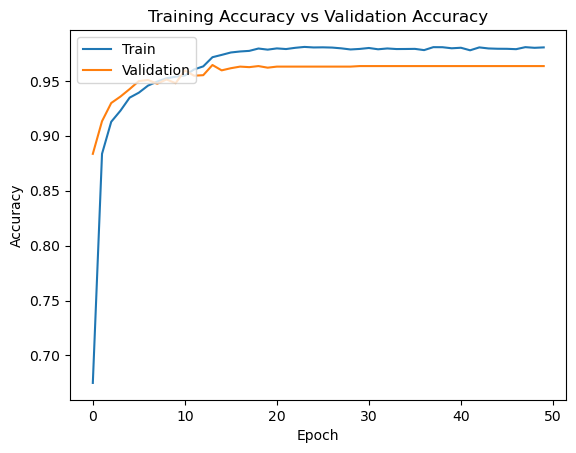

In [23]:
#Plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

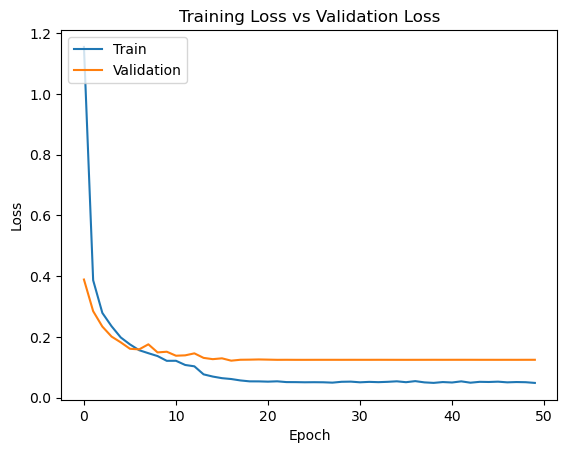

In [24]:
#Plotting the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [25]:
#Predicting the test data
test_eval = model.evaluate(test_X, test_Y)
print("Loss of the model is - " , test_eval[0])
print("Accuracy of the model is - " , test_eval[1])


32/32 [==============================] - 0s 3ms/step - loss: 0.0342 - accuracy: 0.9881
Loss of the model is -  0.03418350964784622
Accuracy of the model is -  0.988095223903656
